## Transformaciones implementadas (Feature Engineering)


### Descripcion General

e generaron variables de forma aleatoria con el fin de mejorar el rendimiento del modelo de forma intuitiva, considerando, por ejemplo, que si la mascota tenia un nombre (HasName) su velocidad de adopcion podría ser mayor.
Se fueron eliminando y/o agregando otras variables en base al analisis del apartado "LGBM Futures Importance" que despliega una serie de gráficos, que muestran las variables mas importantes en el modelado, en base a su influencia en los siguientes parametros: GAIN, SPLIT, Permutation y SHAP Values (relaciones no lineales entre variables).

Estas son las variables que finalmente quedaron:

HasName : Indica si el animal tiene nombre.

PureBreed: Indica si el animal es de raza pura (Breed2 == 0 y no contiene "Mixed.

DescLength: Longitud de la descripción.

Fee_log: Logaritmo del precio para suavizar la distribución y reducir el impacto de valores extremos.

IsFree: Si la adopción es gratis.

Type_Breed_Combo: Combina el tipo de animal con el ID de la raza principal.

Fee_Breed_Ratio: Relación entre la tarifa individual y el promedio de tarifa para su raza.

Fee_per_Pet: Tarifa dividida por cantidad de mascotas.

Photo_per_Pet: Cantidad de fotos por mascota.

Age_Fee_Ratio: Edad dividida por tarifa más 1 (edad vs. valor monetario).

DescLength_per_Pet: Longitud de descripción dividida por cantidad de mascotas.

DescLength_per_Photo: Longitud de descripción dividida por cantidad de fotos.

AgeGroup: Categorias de edades.

### Análisis de Variables

#### Objetivo del análisis

El propósito de esta sección es examinar detalladamente cada una de las variables presentes o construidas a partir del dataset original, evaluando su comportamiento, transformaciones aplicadas y relevancia potencial para predecir la variable objetivo `AdoptionSpeed`. Posteriormente, se comparan estos hallazgos con los resultados obtenidos del modelo LGBM a través de técnicas de evaluación de importancia de variables (GAIN, SPLIT, Permutation y SHAP).

#### Variables analizadas y conclusiones

A continuación, se detallan las variables trabajadas y las conclusiones alcanzadas a partir del análisis exploratorio de datos (EDA):

🔹 Edad (`Age`, `AgeGroup`, `AgeBins`, `Age_Type`)

La edad es la variable más influyente. Los animales jóvenes (especialmente menores de 6 meses) son adoptados con mayor rapidez. Se agruparon en categorías (`AgeGroup`) para facilitar la interpretación, y se combinaron con el tipo de animal (`Age_Type`) para capturar interacciones significativas.

🔹 Descripción (`DescLength`, `DescLength_per_Photo`, `DescLength_per_Pet`)

Las descripciones largas y bien proporcionadas (en relación a la cantidad de fotos o mascotas) tienen un impacto positivo en la adopción. Representan el esfuerzo del rescatista y la calidad de la publicación.

🔹 Tarifa de adopción (`Fee`, `Fee_gratis`, `Fee_paga`, `Fee_Breed_Ratio`)

Si bien el efecto no es lineal, se observa que las mascotas con adopción gratuita suelen tener mayor velocidad de adopción. La relación entre el precio y el promedio de su raza (`Fee_Breed_Ratio`) mejora el modelado de valores inusuales.

🔹 Fotografías (`PhotoAmt`, `Photo_per_Pet`)

El número de fotos es un factor importante: más imágenes tienden a asociarse con mayor adoptabilidad. La variable `Photo_per_Pet` ajusta esta relación en publicaciones de adopciones múltiples.

🔹 Raza (`Breed1`, `Breed2`, `MixedBreed`, `BreedName1`, `BreedName2`)

Algunas razas muestran tasas de adopción más rápidas. Se identificó si es raza mixta o pura (`MixedBreed`) y se incorporaron nombres para combinar con tipo. La combinación `Type_Breed_Combo` fue muy importante en el modelo.

🔹 Tipo y género (`Type`, `Gender`, `Quantity`)

Perros suelen ser adoptados más rápido que gatos. El género tiene un efecto leve pero relevante en interacción con la edad. La cantidad de animales por publicación puede diluir la atención por cada uno.

🔹 Características físicas y sanitarias (`MaturitySize`, `FurLength`, `Health`)

Tamaños medianos y pelajes cortos tienden a facilitar la adopción. Condiciones sanitarias como `Health`, `Sterilized`, `Vaccinated` o `Dewormed` reflejan confianza y cuidado, aunque su impacto directo fue más limitado.

🔹 Coloración (`Color1`, `Color2`, `Color3`, `color_n`, `color_tipo`)

Se analizaron combinaciones y tipos de color, pero no mostraron una relación sólida con la velocidad de adopción.

El modelo LGBM, entrenado con las variables trabajadas, arrojó los siguientes resultados consistentes:

- Las variables más relevantes fueron:

 `Age`, `DescLength_per_Photo`, `DescLength`, `DescLength_per_Pet`, `Type_Breed_Combo`, `Age_Fee_Ratio`, `Photo_per_Pet`

- Variables con bajo impacto según Permutation Importance:

 `VideoAmt`, `HasName`, `Health`, `Color3`, `PureBreed`, `AgeGroup`

- SHAP reveló interacciones importantes especialmente entre `Age` y `Gender`, `Breed1`, y `Breed2`, lo que justifica la exploración de combinaciones como `Age_Type` o segmentaciones cruzadas.



## Configuracion de Entorno

In [1]:
import os

# Si estás en Jupyter Notebook, anclás a una ruta conocida o fija:
project_root = r"C:\Users\juanm\GitHub\UA_MDM_Labo2_G9"  # Personalizar esto

# Alternativa: usar una carpeta conocida dentro del proyecto
# project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Menos frágil

# Rutas de trabajo
workDir = os.path.join(project_root, "work")
optunaArtifactDir = os.path.join(workDir, "optuna_artifacts")
optunaTempDir = os.path.join(workDir, "optuna_temp_artifacts")

# Crear carpetas si no existen
os.makedirs(optunaArtifactDir, exist_ok=True)
os.makedirs(optunaTempDir, exist_ok=True)

# Cambiar al directorio de trabajo solo si es necesario
if os.getcwd() != workDir:
    os.chdir(workDir)

print("Directorio actual:", os.getcwd())


Directorio actual: C:\Users\juanm\GitHub\UA_MDM_Labo2_G9\work


In [2]:
# Manipulación de datos
import numpy as np
import pandas as pd

SEED = 42 #Semilla de procesos aleatorios (para poder replicar exactamente al volver a correr un modelo)
np.random.seed(SEED)

# Modelado: Gradient Boosting
import lightgbm as lgb

# Sklearn: splits, métricas y utilidades
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score
from sklearn.utils import shuffle

# Visualización
import matplotlib.pyplot as plt  # Usar junto con seaborn o plotly si es necesario
import plotly.express as px      # Corrección: no usar `from plotly import express as px`

# Optuna para optimización de hiperparámetros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact
from optuna.samplers import TPESampler

sampler = TPESampler(seed=SEED)  # fijo la semilla global de exploración
TEST_SIZE = 0.2 #Facción para train/test= split

# Utilidades propias
from utiles import plot_confusion_matrix

# Guardado de objetos
from joblib import dump, load

# Sistema
import os

c:\Users\juanm\anaconda3\envs\ldi2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os

# Paths para acceso archivos
#Este notebook asume la siguiente estructura de carpetas a partir de la ubicacion de base_dir 
#(dos niveles arriba de la cƒarpeta donde se ejecuta el notebook). 
# /ƒ/ƒ
# /UA_MDM_Labo2/inputƒ
# /UA_MDM_Labo2/input/petfinder-adoption-prediction/            <- Aca deben ir todos los archivos de datos de la competencia 
# /UA_MDM_Labo2/tutoriales/                       <- Aca deben poner los notebooks y scripts que les compartimos
# /UA_MDM_Labo2/work/                             <- Resultados de notebooks iran dentro de esta carpeta en subcarpetas
# /UA_MDM_Labo2/work/models/                     <- Modelos entrenados en archivos joblibs
# /UA_MDM_Labo2/work/optuna_temp_artifacts/      <- Archivos que queremos dejar como artefacto de un trial de optuna (optuna los copiara a la carpeta de abajo)
# /UA_MDM_Labo2/work/optuna_artifacts/           <- Archivos con artefactos que sibimos a optuna

#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_Labo2
BASE_DIR = '../'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")

#Datos de razas 
PATH_TO_BREED_LABELS = os.path.join(BASE_DIR, "modelo/data/petfinder-adoption-prediction/BreedLabels.csv")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")

## Feature Engineering

In [9]:
import numpy as np
import pandas as pd

# Cargar el dataset
dataset = pd.read_csv(PATH_TO_TRAIN)

# 1. Tiene nombre
dataset['HasName'] = dataset['Name'].notnull().astype(int)

# 2. Es de raza pura
# Cargar etiquetas de razas
breed_labels = pd.read_csv(PATH_TO_BREED_LABELS)

# Diccionario ID → Nombre de raza
id_to_breed = dict(zip(breed_labels['BreedID'], breed_labels['BreedName']))

# Crear una nueva columna con el nombre de Breed1
dataset['Breed1_name'] = dataset['Breed1'].map(id_to_breed)

dataset['PureBreed'] = (
    (dataset['Breed2'] == 0) &
    (~dataset['Breed1_name'].str.contains('Mixed', case=False, na=False))
).astype(int)

# 3. Longitud de la descripción
dataset['DescLength'] = dataset['Description'].fillna('').apply(len)

# 4. Combinación tipo-raza principal
dataset['Type_Breed_Combo'] = dataset['Type'].astype(str) + '_' + dataset['Breed1'].astype(str)

dataset['Type_Breed_Combo'] = dataset['Type_Breed_Combo'].astype('category')

# 5. Tarifa por mascota
dataset['Fee_per_Pet'] = np.where(dataset['Quantity'] == 0, 0, dataset['Fee'] / dataset['Quantity'])

# 6. Fotos por mascota
dataset['Photo_per_Pet'] = np.where(dataset['Quantity'] == 0, 0, dataset['PhotoAmt'] / dataset['Quantity'])

# 7. Relación edad/tarifa
dataset['Age_Fee_Ratio'] = dataset['Age'] / (dataset['Fee'] + 1)

# 8. Longitud descripción por mascota
dataset['DescLength_per_Pet'] = np.where(dataset['Quantity'] == 0, 0, dataset['DescLength'] / dataset['Quantity'])

# 9. Longitud descripción por cantidad de fotos 
dataset['DescLength_per_Photo'] = np.where(dataset['PhotoAmt'] == 0,0,dataset['DescLength'] / dataset['PhotoAmt'])

# 10. Tarifa promedio por raza
breed_fee_mean = dataset.groupby('Breed1')['Fee'].mean()

dataset['Fee_Breed_Ratio'] = dataset['Fee'] / (dataset['Breed1'].map(breed_fee_mean) + 1)

# 11. Categorias de edades
def categorizar_edad(meses):
    if pd.isna(meses):
        return np.nan
    elif meses <= 6:
        return 'Cachorro'
    elif meses <= 24:
        return 'Joven'
    elif meses <= 72:
        return 'Adulto'
    elif meses <= 120:
        return 'Mayor'
    else:
        return 'Anciano'

dataset['AgeGroup'] = dataset['Age'].apply(categorizar_edad)
dataset['AgeGroup'] = pd.Categorical(dataset['AgeGroup'], categories=['Cachorro', 'Joven', 'Adulto', 'Mayor', 'Anciano'], ordered=True)


In [10]:
#Separo un 20% para test estratificado opr target
train, test = train_test_split(dataset,
                               test_size = TEST_SIZE,
                               random_state = SEED,
                               stratify = dataset.AdoptionSpeed)

#Armo listas con features de texto y numericas
char_feats = [f for f in dataset.columns if dataset[f].dtype=='O']
numeric_feats = [f for f in dataset.columns if dataset[f].dtype!='O']

#Defino features a usar
features = numeric_feats.copy()

label = 'AdoptionSpeed'

# Eliminamos 'AdoptionSpeed' si está
if 'AdoptionSpeed' in features:
    features.remove('AdoptionSpeed')

#Genero dataframes de train y test con sus respectivos targets
X_train = train[features]
y_train = train[label]

X_test = test[features]
y_test = test[label]

features

['Type',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'VideoAmt',
 'PhotoAmt',
 'HasName',
 'PureBreed',
 'DescLength',
 'Type_Breed_Combo',
 'Fee_per_Pet',
 'Photo_per_Pet',
 'Age_Fee_Ratio',
 'DescLength_per_Pet',
 'DescLength_per_Photo',
 'Fee_Breed_Ratio',
 'AgeGroup']

## Modelo con hiperparametros por default

In [11]:
#Entreno un modelo inicial sin modificar hiperparametros. Solamente especifico el numero de clases y el tipo de modelo como clasificacoión
lgb_params = params = {
                        'objective': 'multiclass',
                        'num_class': len(y_train.unique()),
                        'seed':SEED
                        }


#genero el objeto Dataset que debo pasarle a lightgbm para que entrene
lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)

#entreno el modelo con los parametros por defecto
lgb_model1 = lgb.train(lgb_params,
                      lgb_train_dataset)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1951
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 30
[LightGBM] [Info] Start training from score -3.599148
[LightGBM] [Info] Start training from score -1.579379
[LightGBM] [Info] Start training from score -1.311924
[LightGBM] [Info] Start training from score -1.526206
[LightGBM] [Info] Start training from score -1.273359


In [12]:
lgb_model1.predict(X_test).argmax(axis=1)

array([2, 2, 2, ..., 1, 4, 4], shape=(2999,))

In [13]:
#Obtengo las predicciones sobre el set de test. El modelo me da una lista de probabilidades para cada clase y tomo la clase con mayor probabilidad con la funcion argmax
y_pred = lgb_model1.predict(X_test).argmax(axis=1)

#Calculo el Kappa
print(cohen_kappa_score(y_test,y_pred, weights = 'quadratic'))

#Muestro la matriz de confusión
display(plot_confusion_matrix(y_test,y_pred))

0.34723658384407885


## Modelo con optimizacion de hiperparametros train/test

In [17]:
from optuna.artifacts import FileSystemArtifactStore, upload_artifact
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump
import matplotlib.pyplot as plt
import os

def lgb_objective(trial):
    # Hiperparámetros
    lgb_params = {
        'objective': 'multiclass',
        'verbosity': -1,
        'num_class': len(y_train.unique()),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'seed':SEED
    }

    # Dataset LightGBM
    lgb_train_dataset = lgb.Dataset(data=X_train, label=y_train)

    # Entrenamiento
    lgb_model2 = lgb.train(lgb_params, lgb_train_dataset)

    # Predicciones
    y_pred_proba = lgb_model2.predict(X_test)
    y_pred = y_pred_proba.argmax(axis=1)

    # Inicializar el store de artefactos
    artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

    # Guardar predicciones
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    pred_df = test.copy()
    pred_df['pred'] = [y_pred_proba[p, :] for p in range(y_pred_proba.shape[0])]
    dump(pred_df, predicted_filename)

    upload_artifact(
        study_or_trial=trial,
        file_path=predicted_filename,
        artifact_store=artifact_store
    )

    # Guardar métrica auxiliar
    test_score = cohen_kappa_score(y_test, y_pred, weights='quadratic')
    trial.set_user_attr("test_score", test_score)

    return test_score


In [18]:
#Defino el estudio a optimizar
study = optuna.create_study(direction='maximize', #buscamos maximizar la metrica
                            storage="sqlite:///../work/db_100_LGBM_FE_JM_100_completo.sqlite3",  # Specify the storage URL here.
                            study_name="100_LGBM_FE_JM_100b_completo", #nombre del experimento
                            load_if_exists=True, #continuar si ya existe
                            sampler=sampler) 

#Corremos 100 trials para buscar mejores parametros
study.optimize(lgb_objective, n_trials=100)

[I 2025-05-09 12:18:14,741] Using an existing study with name '100_LGBM_FE_JM_100b_completo' instead of creating a new one.
[I 2025-05-09 12:18:18,785] Trial 0 finished with value: 0.3167546487146786 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'num_leaves': 188, 'feature_fraction': 0.759195090518222, 'bagging_fraction': 0.4936111842654619, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3167546487146786.
[I 2025-05-09 12:18:22,587] Trial 1 finished with value: 0.30555079982361344 and parameters: {'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'num_leaves': 182, 'feature_fraction': 0.41235069657748147, 'bagging_fraction': 0.9819459112971965, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.3167546487146786.
[I 2025-05-09 12:18:24,740] Trial 2 finished with value: 0.32236767059149873 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07, '

In [20]:
#Obtenemos mejor resultado
study.best_params

{'lambda_l1': 0.038182686620765176,
 'lambda_l2': 0.006963256280710558,
 'num_leaves': 34,
 'feature_fraction': 0.7795782356573911,
 'bagging_fraction': 0.6989823876284834,
 'bagging_freq': 2,
 'min_child_samples': 48}

In [21]:
#Vamos a replicar el resultado de la optimizacion reentrenando el modelo con el mejor conjunto de hiperparametros
#Generamos parametros incluyendo los fijos y la mejor solución que encontro optuna
lgb_params =  {      
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        'seed':SEED} | study.best_params
                        

lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


#Entreno
lgb_model2 = lgb.train(lgb_params,
                    lgb_train_dataset)

#Muestro matriz de confusion y kappa
print(cohen_kappa_score(y_test,lgb_model2.predict(X_test).argmax(axis=1),
                             weights = 'quadratic'))

display(plot_confusion_matrix(y_test,lgb_model2.predict(X_test).argmax(axis=1)))



0.3435703436921834


## Modelo con optimizacion de hiperparametros con 5 Fold Cross Validation

In [13]:
from optuna.artifacts import FileSystemArtifactStore, upload_artifact
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import numpy as np
import os
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(), dy_pred.argmax(axis=1), weights='quadratic')
    is_higher_better = True
    return (metric_name, value, is_higher_better)

def cv_es_lgb_objective(trial):
    
    # Inicio el store de artefactos (archivos) de Optuna
    artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

    # Hiperparámetros a optimizar
    lgb_params = {
        'objective': 'multiclass',
        'verbosity': -1,
        'num_class': len(y_train.unique()),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'n_jobs': -1,
        'seed':SEED
    }
    
    scores_ensemble = np.zeros((len(y_test), len(y_train.unique())))
    score_folds = 0
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):

        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                     label=y_train.iloc[if_index],
                                     free_raw_data=False)
        
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                      label=y_train.iloc[oof_index],
                                      free_raw_data=False)
                
        lgb_model3 = lgb.train(
            lgb_params,
            lgb_if_dataset,
            valid_sets=lgb_oof_dataset,
            callbacks=[lgb.early_stopping(10, verbose=False)],
            feval=lgb_custom_metric_kappa
        )
        
        scores_ensemble += lgb_model3.predict(X_test)

        score_folds += cohen_kappa_score(
            y_train.iloc[oof_index],
            lgb_model3.predict(X_train.iloc[oof_index]).argmax(axis=1),
            weights='quadratic'
        ) / n_splits
    
    # Guardar predicciones sobre test
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    predicted_df = test.copy()
    predicted_df['pred'] = [scores_ensemble[p, :] for p in range(scores_ensemble.shape[0])]
    dump(predicted_df, predicted_filename)

    # Uso keyword arguments en upload_artifact. Asociar las predicciones como artefacto.
    upload_artifact(
        study_or_trial=trial,
        file_path=predicted_filename,
        artifact_store=artifact_store
    )

    # Guardar el score en test como métrica auxiliar
    test_score = cohen_kappa_score(y_test, scores_ensemble.argmax(axis=1), weights='quadratic')
    trial.set_user_attr("test_score", test_score)

    # Devuelvo el promedio de los scores del CV (objetivo a maximizar)
    return score_folds

In [14]:
import optuna

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///../work/db_100_LGBM_FE_JM_100_completo.sqlite3",
                            study_name="100_LGBM_FE_JM_100_Completo_CV",
                            load_if_exists = True,
                            sampler=sampler)

#Corro la optimizacion
study.optimize(cv_es_lgb_objective, n_trials=100)

[I 2025-05-08 15:43:34,245] A new study created in RDB with name: 100_LGBM_FE_JM_100_Completo_CV
[I 2025-05-08 15:43:41,260] Trial 0 finished with value: 0.33049496265078837 and parameters: {'lambda_l1': 0.08916674715636537, 'lambda_l2': 6.143857495033091e-07, 'num_leaves': 3, 'feature_fraction': 0.8892768570729005, 'bagging_fraction': 0.8241144063085704, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 0 with value: 0.33049496265078837.
[I 2025-05-08 15:43:47,524] Trial 1 finished with value: 0.3500096882615593 and parameters: {'lambda_l1': 4.638759594322625e-08, 'lambda_l2': 1.683416412018213e-05, 'num_leaves': 31, 'feature_fraction': 0.9178620555253562, 'bagging_fraction': 0.7739788760965347, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 1 with value: 0.3500096882615593.
[I 2025-05-08 15:43:57,326] Trial 2 finished with value: 0.3396591888233911 and parameters: {'lambda_l1': 6.292756043818863e-06, 'lambda_l2': 8.445977074223802e-06, 'num_leaves': 188, 'feature

## LGBM Importance Futures

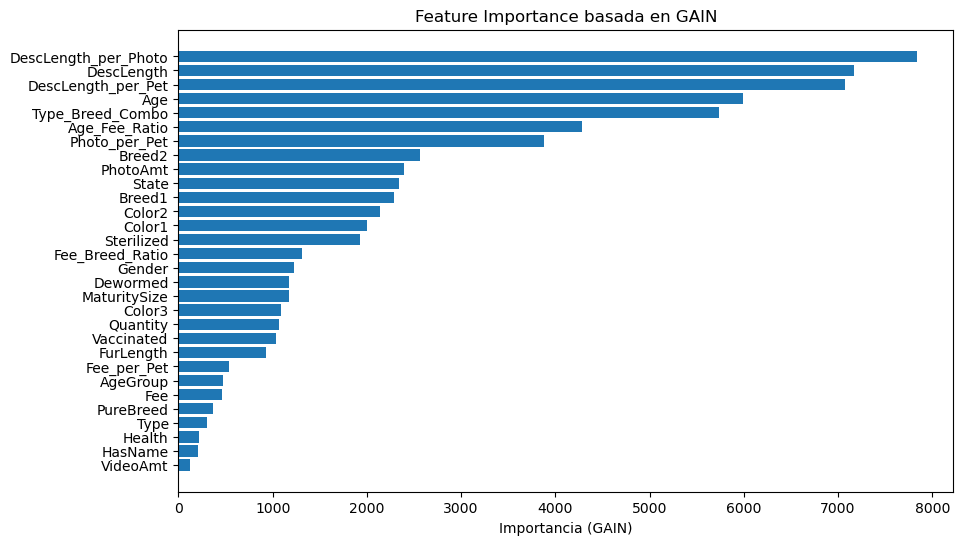

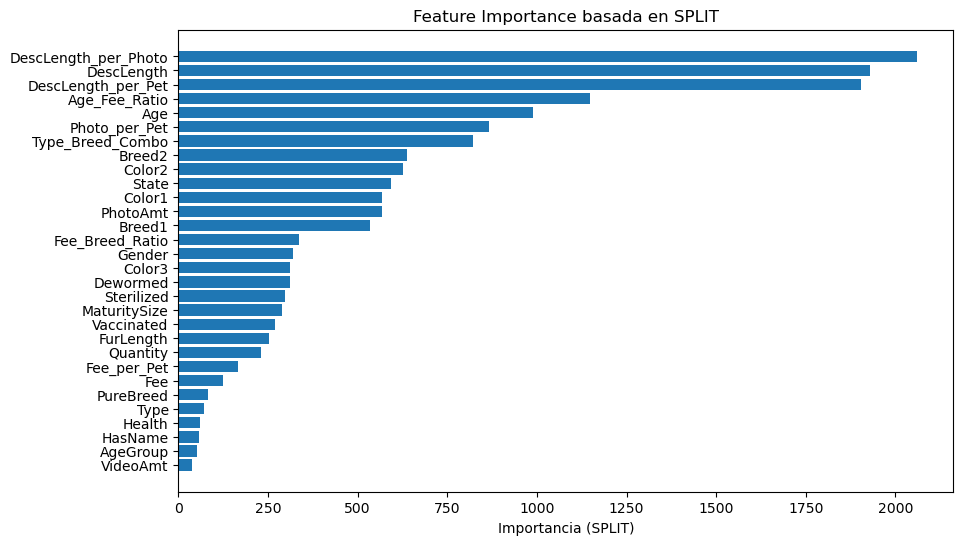

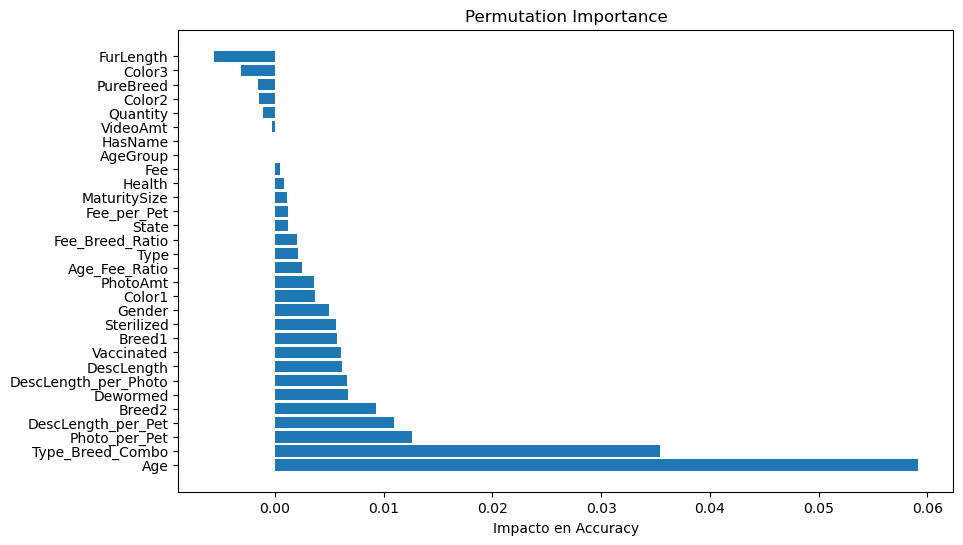

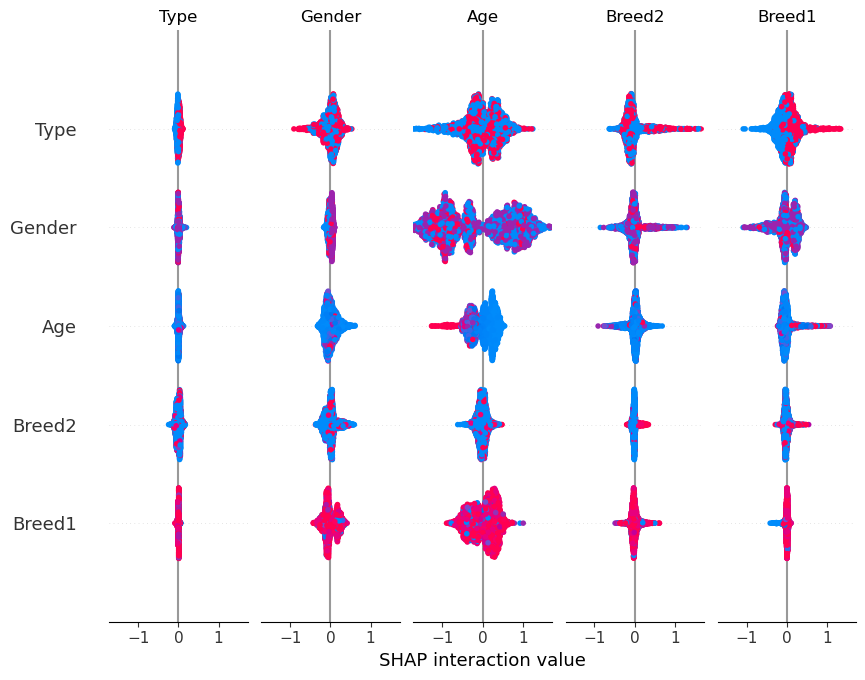

In [22]:
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

features = np.array(features)
model= lgb_model2

# --------------------
# 1. Feature Importance basada en GAIN
# --------------------
importances_gain = model.feature_importance(importance_type='gain')
sorted_idx_gain = importances_gain.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx_gain], importances_gain[sorted_idx_gain])
plt.xlabel('Importancia (GAIN)')
plt.title('Feature Importance basada en GAIN')
plt.gca().invert_yaxis()
plt.show()

# --------------------
# 2. Feature Importance basada en SPLIT
# --------------------
importances_split = model.feature_importance(importance_type='split')
sorted_idx_split = importances_split.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx_split], importances_split[sorted_idx_split])
plt.xlabel('Importancia (SPLIT)')
plt.title('Feature Importance basada en SPLIT')
plt.gca().invert_yaxis()
plt.show()

# --------------------
# 3. Permutation Importance
# --------------------
# Para permutation necesitamos un modelo tipo sklearn, armamos uno rápido
model_sklearn = lgb.LGBMClassifier(boosting_type='gbdt')
model_sklearn.fit(X_train, y_train)

perm_result = permutation_importance(model_sklearn, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')
sorted_idx_perm = perm_result.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx_perm], perm_result.importances_mean[sorted_idx_perm])
plt.xlabel('Impacto en Accuracy')
plt.title('Permutation Importance')
plt.gca().invert_yaxis()
plt.show()

# --------------------
# 4. SHAP Values
# --------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Graficar importancia promedio
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="dot")